# VolGAN Hedging — Adapted for OptionMetrics Data

This notebook implements VolGAN-based hedging for SPX straddles using OptionMetrics data,
making it directly comparable with delta-only and delta-vega strategies.

In [1]:
# === SECTION 1: Imports and Configuration ===
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from scipy.stats import norm
from scipy.interpolate import griddata, interp1d
from sklearn.linear_model import LassoCV

# Configuration
TRADING_DAYS_PER_MONTH = 21
OPTIONS_PARQUET = "../data/options_dataset.parquet"
OM_UNDERLYING_CSV = "../data/OMunderlying.csv"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


In [2]:
# === SECTION 2: Data Loading Functions ===

def load_om_data_for_volgan(options_path, underlying_path):
    """Load and prepare OptionMetrics data for VolGAN."""
    # Load options
    df_opt = pd.read_parquet(options_path)
    df_opt = df_opt[df_opt['ticker'] == 'SPX'].copy()
    df_opt['date'] = pd.to_datetime(df_opt['date'])
    df_opt['exdate'] = pd.to_datetime(df_opt['exdate'])
    
    # Strike scaling
    if df_opt['strike_price'].median() > 1e4:
        df_opt['strike_price'] = df_opt['strike_price'] / 1000.0
    
    df_opt['dte'] = (df_opt['exdate'] - df_opt['date']).dt.days
    df_opt['mid'] = (df_opt['best_bid'] + df_opt['best_offer']) / 2.0
    
    # Load spot
    df_spot = pd.read_csv(underlying_path)
    df_spot['date'] = pd.to_datetime(df_spot['date'])
    df_spot = df_spot[df_spot['ticker'] == 'SPX'][['date', 'close']].rename(columns={'close': 'spot'})
    df_spot = df_spot.drop_duplicates('date').sort_values('date')
    
    # Merge
    df_opt = df_opt.merge(df_spot, on='date', how='inner')
    df_opt['moneyness'] = df_opt['strike_price'] / df_opt['spot']
    
    return df_opt, df_spot

In [3]:
# # === SECTION 3: Load Raw Data ===

# df_options, df_underlying = load_om_data_for_volgan(OPTIONS_PARQUET, OM_UNDERLYING_CSV)
# print(f"Loaded: {len(df_options)} option rows, {len(df_underlying)} spot rows")
# print(f"Date range: {df_options['date'].min()} to {df_options['date'].max()}")
# df_options.head()

# === SECTION 3: Load and Quality-Filter Raw Data ===

df_options, df_underlying = load_om_data_for_volgan(OPTIONS_PARQUET, OM_UNDERLYING_CSV)
print(f"Raw data loaded: {len(df_options)} option rows")

# === Quality Screening (Same as Delta/Delta-Vega notebooks) ===

# Merge spot and compute moneyness
df = df_options.copy()  # Already has spot from load_om_data_for_volgan
df['moneyness'] = df['strike_price'] / df['spot']

# Filter to ~1-month maturity (15-35 calendar days)
df_1m = df[(df['dte'] >= 15) & (df['dte'] <= 35)].copy()
print(f"After DTE filter (15-35 days): {len(df_1m)} rows")

# Quality filters
df_1m = df_1m.replace([np.inf, -np.inf], np.nan)
df_1m = df_1m.dropna(subset=['mid', 'delta', 'vega', 'best_bid', 'best_offer'])
df_1m = df_1m[df_1m['best_offer'] >= df_1m['best_bid']].copy()

# Compute spread metrics
df_1m['spread'] = (df_1m['best_offer'] - df_1m['best_bid']).clip(lower=0)
df_1m['rel_spread'] = (df_1m['spread'] / df_1m['mid']).replace([np.inf, -np.inf], np.nan)

# Liquidity screens
liq_mask = (
    (df_1m['mid'] > 0.05) &
    (df_1m['rel_spread'] <= 0.35) &
    df_1m['delta'].between(-1.1, 1.1) &
    (df_1m['vega'] > 0)
)
df_1m = df_1m[liq_mask].copy()

print(f"After quality filters: {len(df_1m)} rows")
print(f"Date range: {df_1m['date'].min().date()} → {df_1m['date'].max().date()}")
print(f"Coverage: {len(df_1m['date'].unique())} unique trading days")

# Keep relevant columns
cols_keep = ['date', 'exdate', 'cp_flag', 'strike_price', 'spot', 'moneyness', 
             'dte', 'mid', 'best_bid', 'best_offer', 'volume', 'open_interest', 
             'delta', 'vega', 'impl_volatility', 'spread', 'rel_spread']

# Check which columns exist
cols_available = [c for c in cols_keep if c in df_1m.columns]
df_1m_filtered = df_1m[cols_available].sort_values(['date', 'dte', 'strike_price']).reset_index(drop=True)

print(f"\nFinal filtered dataset: {len(df_1m_filtered)} rows")
df_1m_filtered.head(10)


Raw data loaded: 36251366 option rows
After DTE filter (15-35 days): 7465938 rows
After quality filters: 5689084 rows
Date range: 2000-01-03 → 2023-08-31
Coverage: 5099 unique trading days

Final filtered dataset: 5689084 rows


,date,exdate,cp_flag,strike_price,spot,moneyness,dte,mid,best_bid,best_offer,volume,open_interest,delta,vega,impl_volatility,spread,rel_spread
0,2000-01-03,2000-01-22,P,1275.0,1455.22,0.876156,19,2.0000,1.750,2.250,585,23785,-0.041295,28.57753,0.358787,0.500,0.250000
1,2000-01-03,2000-01-22,P,1300.0,1455.22,0.893336,19,2.6250,2.250,3.000,3572,26621,-0.055490,36.20153,0.334738,0.750,0.285714
2,2000-01-03,2000-01-22,P,1325.0,1455.22,0.910515,19,3.8125,3.500,4.125,1406,30757,-0.079749,47.92918,0.317378,0.625,0.163934
3,2000-01-03,2000-01-22,C,1325.0,1455.22,0.910515,19,134.5000,133.500,135.500,315,29529,0.983012,13.61578,0.207545,2.000,0.014870
4,2000-01-03,2000-01-22,C,1350.0,1455.22,0.927695,19,111.1250,110.125,112.125,112,20500,0.939732,38.63064,0.229941,2.000,0.017998
5,2000-01-03,2000-01-22,P,1350.0,1455.22,0.927695,19,5.1875,4.875,5.500,819,24413,-0.109956,60.74824,0.294041,0.625,0.120482
6,2000-01-03,2000-01-22,C,1375.0,1455.22,0.944874,19,88.5000,87.500,89.500,6,7885,0.884385,62.96457,0.229135,2.000,0.022599
7,2000-01-03,2000-01-22,P,1375.0,1455.22,0.944874,19,6.9375,6.750,7.125,2633,18270,-0.150684,75.57642,0.267472,0.375,0.054054
8,2000-01-03,2000-01-22,C,1380.0,1455.22,0.948310,19,84.0000,83.000,85.000,4,13,0.872528,67.43791,0.226489,2.000,0.023810
9,2000-01-03,2000-01-22,P,1380.0,1455.22,0.948310,19,8.1250,7.625,8.625,69,1458,-0.168821,81.41239,0.271506,1.000,0.123077


In [4]:
# === SECTION 4: Build IV Surface Grid (ROBUST VERSION) ===

def build_iv_surface_grid_robust(df_opt, m_grid=np.linspace(0.6, 1.4, 10), 
                                 dte_grid=[7, 14, 30, 60, 91, 122, 152, 182]):
    """
    Build IV surface with robust handling of days with insufficient data spread.
    """
    from scipy.interpolate import griddata, interp1d
    
    dates = sorted(df_opt['date'].unique())
    surfaces = []
    valid_dates = []
    
    for d in tqdm(dates, desc="Building IV surfaces"):
        day_df = df_opt[df_opt['date'] == d]
        points = day_df[['moneyness', 'dte', 'impl_volatility']].dropna()
        
        if len(points) < 10:
            continue
        
        # Check if we have variety in BOTH dimensions
        unique_dte = points['dte'].nunique()
        unique_moneyness = points['moneyness'].nunique()
        
        if unique_dte < 2 or unique_moneyness < 3:
            # Not enough variety for 2D interpolation, skip this day
            continue
        
        # Check if DTE spread covers our grid adequately
        dte_min, dte_max = points['dte'].min(), points['dte'].max()
        if dte_max - dte_min < 10:
            # Too narrow DTE range, skip
            continue
        
        grid_m, grid_dte = np.meshgrid(m_grid, dte_grid)
        
        try:
            # Try linear interpolation
            iv_surface = griddata(
                points[['moneyness', 'dte']].values,
                points['impl_volatility'].values,
                (grid_m, grid_dte),
                method='linear',
                fill_value=np.nan
            )
            
            # Fill NaNs with nearest neighbor
            if np.isnan(iv_surface).any():
                iv_surface_filled = griddata(
                    points[['moneyness', 'dte']].values,
                    points['impl_volatility'].values,
                    (grid_m, grid_dte),
                    method='nearest'
                )
                iv_surface = np.where(np.isnan(iv_surface), iv_surface_filled, iv_surface)
            
            # Additional check: if still >50% NaN, skip
            if np.isnan(iv_surface).sum() > 0.5 * iv_surface.size:
                continue
            
            # Flatten and append
            surfaces.append(iv_surface.T.flatten())
            valid_dates.append(d)
            
        except Exception as e:
            # Skip days with interpolation errors
            continue
    
    if len(surfaces) == 0:
        raise ValueError("No valid surfaces could be constructed! Check data quality.")
    
    surfaces_transform = np.array(surfaces)
    tau_grid = np.array(dte_grid) / 365.0
    
    print(f"\nSurface construction summary:")
    print(f"  Total dates attempted: {len(dates)}")
    print(f"  Valid surfaces built: {len(valid_dates)}")
    print(f"  Success rate: {100 * len(valid_dates) / len(dates):.1f}%")
    
    return surfaces_transform, valid_dates, m_grid, tau_grid

# %%
# Run surface building with robust function
m_grid = np.linspace(0.6, 1.4, 10)
dte_grid = [7, 14, 30, 60, 91, 122, 152, 182]

surfaces_transform, dates_volgan, m, tau = build_iv_surface_grid_robust(
    df_1m_filtered, m_grid, dte_grid
)

print(f"\nSurface grid shape: {surfaces_transform.shape}")
print(f"Expected: ({len(dates_volgan)}, {len(m_grid) * len(dte_grid)})")


Building IV surfaces: 100%|██████████| 5099/5099 [00:32<00:00, 158.80it/s]


Surface construction summary:
  Total dates attempted: 5099
  Valid surfaces built: 2934
  Success rate: 57.5%

Surface grid shape: (2934, 80)
Expected: (2934, 80)


In [5]:
# === SECTION 5: Prepare VolGAN Training Data ===

def prepare_volgan_data_om(surfaces, dates_list, df_spot):
    """Prepare condition and target arrays for VolGAN."""
    dates_pd = pd.to_datetime(dates_list)
    spot_df = df_spot[df_spot['date'].isin(dates_pd)].sort_values('date')
    prices = spot_df['spot'].values
    
    # Log returns
    prices_prev = np.zeros(len(prices))
    prices_prev[1:] = prices[:-1]
    prices_prev[0] = prices[0]
    log_rtn = np.log(prices) - np.log(prices_prev)
    
    # Realized volatility (21-day rolling)
    realised_vol_tm1 = np.zeros(len(log_rtn) - 22)
    for i in range(len(realised_vol_tm1)):
        realised_vol_tm1[i] = np.sqrt(252 / 21) * np.sqrt(np.sum(log_rtn[i:(i+21)]**2))
    
    # Align dates
    dates_t = dates_pd[22:]
    log_rtn_t = log_rtn[22:]
    log_rtn_tm1 = np.sqrt(252) * log_rtn[21:-1]
    log_rtn_tm2 = np.sqrt(252) * log_rtn[20:-2]
    
    # Log IV surfaces
    log_iv_t = np.log(surfaces[22:])
    log_iv_tm1 = np.log(surfaces[21:-1])
    log_iv_inc_t = log_iv_t - log_iv_tm1
    
    # Condition: [r_{t-1}, r_{t-2}, RV_{t-1}, log_iv_{t-1}]
    condition = np.concatenate((
        np.expand_dims(log_rtn_tm1, axis=1),
        np.expand_dims(log_rtn_tm2, axis=1),
        np.expand_dims(realised_vol_tm1, axis=1),
        log_iv_tm1
    ), axis=1)
    
    # Target: [r_t, log_iv_inc_t]
    log_rtn_t_ann = np.sqrt(252) * log_rtn_t
    true = np.concatenate((
        np.expand_dims(log_rtn_t_ann, axis=1),
        log_iv_inc_t
    ), axis=1)
    
    return true, condition, dates_t

true, condition, dates_volgan_aligned = prepare_volgan_data_om(
    surfaces_transform, dates_volgan, df_underlying
)
print(f"VolGAN data shapes: true={true.shape}, condition={condition.shape}")

VolGAN data shapes: true=(2912, 81), condition=(2912, 83)


In [6]:
# %%
# === SECTION 5B: Train/Validation/Test Split for VolGAN Training ===

# Define splits
train_end = pd.Timestamp('2019-12-31')  # Train: up to 2019
val_end = pd.Timestamp('2020-12-31')    # Validation: 2020
# Test: 2021 onwards (for backtest)

dates_pd = pd.to_datetime(dates_volgan_aligned)

# Create masks
train_mask = dates_pd <= train_end
val_mask = (dates_pd > train_end) & (dates_pd <= val_end)
test_mask = dates_pd > val_end

# Convert to tensors
true_train = torch.tensor(true[train_mask], dtype=torch.float, device=device)
true_val = torch.tensor(true[val_mask], dtype=torch.float, device=device)
true_test = torch.tensor(true[test_mask], dtype=torch.float, device=device)

condition_train = torch.tensor(condition[train_mask], dtype=torch.float, device=device)
condition_val = torch.tensor(condition[val_mask], dtype=torch.float, device=device)
condition_test = torch.tensor(condition[test_mask], dtype=torch.float, device=device)

print(f"Data split:")
print(f"  - Train: {true_train.shape[0]} samples (up to {train_end.date()})")
print(f"  - Validation: {true_val.shape[0]} samples ({train_end.date()} to {val_end.date()})")
print(f"  - Test: {true_test.shape[0]} samples (after {val_end.date()})")
print(f"  - Condition dim: {condition_train.shape[1]}")
print(f"  - Target dim: {true_train.shape[1]}")


Data split:
  - Train: 1989 samples (up to 2019-12-31)
  - Validation: 253 samples (2019-12-31 to 2020-12-31)
  - Test: 670 samples (after 2020-12-31)
  - Condition dim: 83
  - Target dim: 81


In [7]:
# === SECTION 6: VolGAN Model Classes ===

class Generator(nn.Module):
    def __init__(self, noise_dim, cond_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.linear1 = nn.Linear(noise_dim + cond_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.linear3 = nn.Linear(hidden_dim * 2, output_dim)
        self.activation = nn.Softplus()
    
    def forward(self, noise, condition):
        out = torch.cat([noise, condition], dim=-1).to(torch.float)
        out = self.activation(self.linear1(out))
        out = self.activation(self.linear2(out))
        out = self.linear3(out)
        return out

class Discriminator(nn.Module):
    def __init__(self, in_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Linear(in_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 1)
        self.activation = nn.Softplus()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.activation(self.linear1(x))
        out = self.sigmoid(self.linear2(out))
        return out

In [8]:
# === SECTION 7: Black-Scholes Pricing Functions ===

def BS_call(S, tau, K, sigma, r=0):
    d1 = (np.log(S/K) + tau*(r + 0.5*sigma**2)) / (sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    return S*norm.cdf(d1) - K*norm.cdf(d2)*np.exp(-r*tau)

def BS_put(S, tau, K, sigma, r=0):
    d1 = (np.log(S/K) + tau*(r + 0.5*sigma**2)) / (sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    return K*norm.cdf(-d2)*np.exp(-r*tau) - S*norm.cdf(-d1)

In [9]:
# === SECTION 8: VolGAN Hedging Function ===

def hedge_with_volgan(gen, condition_t, spot_t, K_straddle, hedge_options, 
                      m_grid, tau_grid, n_scenarios=1000, device='cpu'):
    """Generate scenarios and compute LASSO hedge ratios."""
    gen.eval()
    with torch.no_grad():
        noise = torch.randn((n_scenarios, gen.noise_dim), device=device)
        condition_batch = condition_t.unsqueeze(0).repeat(n_scenarios, 1)
        fake = gen(noise, condition_batch)
        spot_ret_scenarios = fake[:, 0].cpu().numpy() / np.sqrt(252)
        log_iv_inc_scenarios = fake[:, 1:].cpu().numpy()
    
    spot_t1_scenarios = spot_t * np.exp(spot_ret_scenarios)
    iv_current = np.exp(condition_t[3:].cpu().numpy())
    
    V_scenarios = []
    for i in range(n_scenarios):
        S_t1 = spot_t1_scenarios[i]
        iv_t1 = iv_current * np.exp(log_iv_inc_scenarios[i])
        iv_surface = iv_t1.reshape(len(m_grid), len(tau_grid))
        
        m_straddle = K_straddle / S_t1
        tau_straddle = 21 / 365
        
        iv_at_tau = interp1d(tau_grid, iv_surface, axis=1, 
                             bounds_error=False, fill_value='extrapolate')(tau_straddle)
        iv_interp = np.clip(np.interp(m_straddle, m_grid, iv_at_tau), 0.01, 2.0)
        
        V_call = BS_call(S_t1, tau_straddle, K_straddle, iv_interp, r=0)
        V_put = BS_put(S_t1, tau_straddle, K_straddle, iv_interp, r=0)
        V_scenarios.append(V_call + V_put)
    
    V_scenarios = np.array(V_scenarios)
    
    # Hedge instruments
    H_scenarios = {'spot': spot_t1_scenarios}
    
    for opt in hedge_options:
        H_values = []
        for i in range(n_scenarios):
            S_t1 = spot_t1_scenarios[i]
            iv_t1 = iv_current * np.exp(log_iv_inc_scenarios[i])
            iv_surface = iv_t1.reshape(len(m_grid), len(tau_grid))
            
            m_opt = opt['K'] / S_t1
            tau_opt = 21 / 365
            
            iv_at_tau = interp1d(tau_grid, iv_surface, axis=1, 
                                 bounds_error=False, fill_value='extrapolate')(tau_opt)
            iv_opt = np.clip(np.interp(m_opt, m_grid, iv_at_tau), 0.01, 2.0)
            
            if opt['cp'] == 'C':
                H_val = BS_call(S_t1, tau_opt, opt['K'], iv_opt, r=0)
            else:
                H_val = BS_put(S_t1, tau_opt, opt['K'], iv_opt, r=0)
            H_values.append(H_val)
        
        H_scenarios[f"{opt['cp']}_{opt['K']}"] = np.array(H_values)
    
    # LASSO regression
    X = pd.DataFrame(H_scenarios)
    y = V_scenarios
    
    lasso = LassoCV(alphas=np.logspace(-4, 0, 20), cv=3, max_iter=5000)
    lasso.fit(X, y)
    
    hedge_ratios = {instr: coef for instr, coef in zip(X.columns, lasso.coef_)}
    return hedge_ratios

In [10]:
# === SECTION 9: Utility Functions for Backtest ===

def get_window_dates(df_all, start_idx):
    dates = np.sort(df_all['date'].unique())
    if start_idx + TRADING_DAYS_PER_MONTH >= len(dates):
        return None
    return list(dates[start_idx:start_idx + TRADING_DAYS_PER_MONTH + 1])

def choose_strike_for_m0(spot0, m0, strikes):
    target = m0 * spot0
    return float(strikes[np.abs(strikes - target).argmin()])

def pick_one(day_df, strike, cp_flag):
    sub = day_df[(day_df['strike_price'] == strike) & (day_df['cp_flag'] == cp_flag)].copy()
    if sub.empty:
        return None
    sub = sub.dropna(subset=['mid', 'delta', 'vega'])
    sub = sub[sub['best_offer'] >= sub['best_bid']]
    if sub.empty:
        return None
    sub = sub.sort_values(by=['open_interest', 'volume'], ascending=[False, False])
    return sub.iloc[0]

def fetch_next_row(next_df, strike, cp_flag):
    nxt = next_df[(next_df['strike_price'] == strike) & (next_df['cp_flag'] == cp_flag)]
    if nxt.empty:
        return None
    nxt = nxt.dropna(subset=['mid'])
    nxt = nxt.sort_values(by=['open_interest', 'volume'], ascending=[False, False])
    return nxt.iloc[0]

In [11]:
# === SECTION 10: Single Window Runner ===

def run_volgan_window(df_all, gen, start_idx, m0, m_grid, tau_grid, 
                      condition_data, dates_data, device='cpu'):
    """Run one 21-day VolGAN hedging window."""
    days = get_window_dates(df_all, start_idx)
    if days is None:
        return None
    
    d0 = pd.Timestamp(days[0])
    day0 = df_all[df_all['date'] == d0]
    if day0.empty:
        return None
    
    spot0 = float(day0['spot'].iloc[0])
    strikes0 = np.sort(day0['strike_price'].unique())
    K_straddle = choose_strike_for_m0(spot0, m0, strikes0)
    
    hedge_options = [
        {'K': K_straddle, 'cp': 'C'},
        {'K': K_straddle, 'cp': 'P'},
        {'K': K_straddle * 0.9, 'cp': 'P'},
        {'K': K_straddle * 1.1, 'cp': 'C'},
    ]
    
    records = []
    V0, Pi_t = None, None
    phi_prev = {}
    
    for t in range(len(days) - 1):
        d, d_next = pd.Timestamp(days[t]), pd.Timestamp(days[t + 1])
        
        day = df_all[df_all['date'] == d]
        day_next = df_all[df_all['date'] == d_next]
        
        if day.empty or day_next.empty:
            return None
        
        row_C = pick_one(day, K_straddle, 'C')
        row_P = pick_one(day, K_straddle, 'P')
        if row_C is None or row_P is None:
            return None
        
        V_t = row_C['mid'] + row_P['mid']
        spot_t = row_C['spot']
        
        if V0 is None:
            V0 = V_t
            Pi_t = V0
        
        # Get VolGAN condition
        try:
            date_idx = np.where(dates_data == d)[0][0]
            condition_t = torch.tensor(condition_data[date_idx], dtype=torch.float, device=device)
        except (IndexError, ValueError):
            return None
        
        hedge_ratios = hedge_with_volgan(
            gen, condition_t, spot_t, K_straddle, hedge_options,
            m_grid, tau_grid, n_scenarios=1000, device=device
        )
        
        row_C_next = fetch_next_row(day_next, K_straddle, 'C')
        row_P_next = fetch_next_row(day_next, K_straddle, 'P')
        if row_C_next is None or row_P_next is None:
            return None
        
        spot_t1 = row_C_next['spot']
        V_t1 = row_C_next['mid'] + row_P_next['mid']
        
        pnl_total = 0
        cost_total = 0
        
        phi_spot = hedge_ratios.get('spot', 0)
        pnl_total += phi_spot * (spot_t1 - spot_t)
        
        for opt in hedge_options:
            key = f"{opt['cp']}_{opt['K']}"
            phi_opt = hedge_ratios.get(key, 0)
            
            opt_t = pick_one(day, opt['K'], opt['cp'])
            opt_t1 = fetch_next_row(day_next, opt['K'], opt['cp'])
            
            if opt_t is not None and opt_t1 is not None:
                pnl_total += phi_opt * (opt_t1['mid'] - opt_t['mid'])
                phi_opt_prev = phi_prev.get(key, 0)
                cost_total += abs(phi_opt - phi_opt_prev) * (opt_t['best_offer'] - opt_t['best_bid']) / 2.0
        
        Pi_t1 = Pi_t + pnl_total - cost_total
        
        records.append({
            'date': d,
            'V_t': V_t,
            'Pi_t': Pi_t,
            'Pi_t1': Pi_t1,
            'pnl_hedged': pnl_total - cost_total,
            'pnl_unhedged': V_t1 - V_t
        })
        
        phi_prev = hedge_ratios.copy()
        Pi_t = Pi_t1
    
    # Final valuation
    last_day, final_day = pd.Timestamp(days[-2]), pd.Timestamp(days[-1])
    day_last = df_all[df_all['date'] == last_day]
    day_final = df_all[df_all['date'] == final_day]
    
    row_C_fin = fetch_next_row(day_final, K_straddle, 'C')
    row_P_fin = fetch_next_row(day_final, K_straddle, 'P')
    
    if row_C_fin is None or row_P_fin is None:
        return None
    
    V_T = row_C_fin['mid'] + row_P_fin['mid']
    Pi_T = records[-1]['Pi_t1']
    
    summary = {
        'start': days[0],
        'end': days[-1],
        'm0': m0,
        'V0': V0,
        'V_T': V_T,
        'Pi_T': Pi_T,
        'tracking_error': V_T - Pi_T,
        'pnl_unhedged': V_T - V0,
        'pnl_hedged': Pi_T - V0,
        'strategy': 'VolGAN'
    }
    
    return {'timeline': pd.DataFrame(records), 'summary': summary}

In [12]:
# === SECTION 11: Multi-Window Experiment ===

def run_volgan_experiment(df_all, gen, m0_list, condition_data, dates_data,
                          m_grid, tau_grid, max_windows=52, device='cpu'):
    """Run VolGAN across multiple windows."""
    dates = np.sort(df_all['date'].unique())
    start_indices = list(range(0, len(dates) - TRADING_DAYS_PER_MONTH - 1, TRADING_DAYS_PER_MONTH))
    start_indices = start_indices[:max_windows]
    
    results = []
    for m0 in m0_list:
        print(f"\n===== VolGAN: m0={m0} =====")
        for i, si in enumerate(start_indices, 1):
            print(f"Window {i}/{len(start_indices)}")
            out = run_volgan_window(
                df_all, gen, si, m0, m_grid, tau_grid,
                condition_data, dates_data, device
            )
            if out is not None:
                results.append(out['summary'])
    
    return pd.DataFrame(results)

In [13]:
# === SECTION 12: Prepare Backtest DataFrame ===

# Filter options to 1-month maturity
# Check if 'spot' already exists in df_options
if 'spot' in df_options.columns:
    print("'spot' column already exists in df_options")
    df = df_options.copy()
else:
    # If not, merge with df_underlying
    df = df_options.merge(df_underlying, on='date', how='inner', suffixes=('', '_y'))
    if 'spot_y' in df.columns:
        df['spot'] = df['spot_y']
        df = df.drop(columns=['spot_y'])

# Ensure moneyness is computed
if 'moneyness' not in df.columns:
    df['moneyness'] = df['strike_price'] / df['spot']

# Filter to ~1-month maturity (15-35 days)
df_1m = df[(df['dte'] >= 15) & (df['dte'] <= 35)].copy()

# Quality filters
df_1m = df_1m.replace([np.inf, -np.inf], np.nan)
df_1m = df_1m.dropna(subset=['mid', 'delta', 'vega', 'best_bid', 'best_offer', 'spot'])
df_1m = df_1m[df_1m['best_offer'] >= df_1m['best_bid']]
df_1m['spread'] = (df_1m['best_offer'] - df_1m['best_bid']).clip(lower=0)
df_1m['rel_spread'] = df_1m['spread'] / df_1m['mid']

# Liquidity filters
liq = (
    (df_1m['mid'] > 0.05) &
    (df_1m['rel_spread'] <= 0.35) &
    df_1m['delta'].between(-1.1, 1.1) &
    (df_1m['vega'] > 0)
)
df_1m = df_1m[liq].copy()

# Filter to backtest period
start_backtest = pd.Timestamp("2021-01-01")
df_1m_bt = df_1m[df_1m['date'] >= start_backtest].copy()
print(f"Backtest  {len(df_1m_bt)} rows from {df_1m_bt['date'].min()} to {df_1m_bt['date'].max()}")

'spot' column already exists in df_options
Backtest  2181138 rows from 2021-01-04 00:00:00 to 2023-08-31 00:00:00


In [14]:
# === SECTION 13: Filter Test Data for VolGAN ===

# Define train/test split
train_end = pd.Timestamp('2020-12-31')
dates_pd = pd.to_datetime(dates_volgan_aligned)
test_mask = dates_pd > train_end

# Extract test data
condition_test_raw = condition[test_mask]
dates_test_raw = dates_pd[test_mask]

# Filter to overlap with backtest dates
dates_in_backtest = df_1m_bt['date'].unique()
mask_overlap = np.isin(dates_test_raw, dates_in_backtest)

condition_test_filtered = condition_test_raw[mask_overlap]
dates_test_filtered = dates_test_raw[mask_overlap]

print(f"VolGAN test  {len(dates_test_filtered)} dates")
print(f"Coverage: {dates_test_filtered.min()} to {dates_test_filtered.max()}")

VolGAN test  670 dates
Coverage: 2021-01-04 00:00:00 to 2023-08-31 00:00:00


In [15]:
# === SECTION 13A: Initialize Models ===

# Dimensions
noise_dim = 20
cond_dim = 3 + 80  # 3 (r_tm1, r_tm2, RV_tm1) + 80 (log IV surface)
hidden_dim = 128
output_dim = 1 + 80  # 1 (spot return) + 80 (log IV increment)

# Initialize generator and discriminator
gen = Generator(noise_dim=noise_dim, cond_dim=cond_dim, hidden_dim=hidden_dim, output_dim=output_dim)
disc = Discriminator(in_dim=cond_dim + output_dim, hidden_dim=hidden_dim)

gen.to(device)
disc.to(device)

print(f"Generator parameters: {sum(p.numel() for p in gen.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in disc.parameters()):,}")

Generator parameters: 67,153
Discriminator parameters: 21,249


In [16]:
# === SECTION 13B: Gradient Matching

def gradient_matching(gen, disc, condition_train, true_train, m_grid, tau_grid, 
                     n_epochs=5, batch_size=64, lr_g=0.00005, lr_d=0.00005, device='cpu'):
    """Pre-training to find penalty weights."""
    gen_opt = torch.optim.Adam(gen.parameters(), lr=lr_g, betas=(0.5, 0.999))
    disc_opt = torch.optim.Adam(disc.parameters(), lr=lr_d, betas=(0.5, 0.999))
    criterion = nn.BCELoss()
    
    n_train = condition_train.shape[0]
    n_batches = n_train // batch_size + 1
    
    lk, lt = len(m_grid), len(tau_grid)  # 10, 8
    Ngrid = lk * lt  # 80
    
    # === Simplified smoothness penalties (L2 regularization on finite differences) ===
    BCE_grads = []
    m_smooth_grads = []
    t_smooth_grads = []
    
    gen.train()
    for epoch in tqdm(range(n_epochs), desc="Gradient matching"):
        perm = torch.randperm(n_train)
        condition_train_perm = condition_train[perm]
        true_train_perm = true_train[perm]
        
        for i in range(n_batches):
            curr_batch_size = min(batch_size, n_train - i*batch_size)
            condition = condition_train_perm[i*batch_size:i*batch_size + curr_batch_size]
            real = true_train_perm[i*batch_size:i*batch_size + curr_batch_size]
            surface_past = condition[:, 3:]
            
            # Update discriminator
            disc_opt.zero_grad()
            noise = torch.randn((curr_batch_size, gen.noise_dim), device=device, dtype=torch.float)
            fake = gen(noise, condition)
            
            real_and_cond = torch.cat((condition, real), dim=-1)
            fake_and_cond = torch.cat((condition, fake), dim=-1)
            
            disc_fake_pred = disc(fake_and_cond.detach())
            disc_real_pred = disc(real_and_cond)
            
            disc_loss = (criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred)) +
                        criterion(disc_real_pred, torch.ones_like(disc_real_pred))) / 2
            disc_loss.backward()
            disc_opt.step()
            
            # === Measure generator gradients ===
            gen_opt.zero_grad()
            noise = torch.randn((curr_batch_size, gen.noise_dim), device=device, dtype=torch.float)
            fake = gen(noise, condition)
            fake_surface = torch.exp(fake[:, 1:] + surface_past)  # Shape: (batch, 80)
            
            # Reshape to (batch, lk, lt) for easier differencing
            fake_surface_grid = fake_surface.reshape(curr_batch_size, lk, lt)
            
            # Moneyness smoothness (differences along dim 1)
            m_diffs = fake_surface_grid[:, 1:, :] - fake_surface_grid[:, :-1, :]  # (batch, lk-1, lt)
            m_penalty = torch.mean(m_diffs ** 2)
            
            m_penalty.backward(retain_graph=True)
            m_grad_norm = sum(p.grad.data.norm(2).item()**2 for p in gen.parameters() if p.grad is not None)**0.5
            m_smooth_grads.append(m_grad_norm)
            gen_opt.zero_grad()
            
            # Temporal smoothness (differences along dim 2)
            t_diffs = fake_surface_grid[:, :, 1:] - fake_surface_grid[:, :, :-1]  # (batch, lk, lt-1)
            t_penalty = torch.mean(t_diffs ** 2)
            
            t_penalty.backward(retain_graph=True)
            t_grad_norm = sum(p.grad.data.norm(2).item()**2 for p in gen.parameters() if p.grad is not None)**0.5
            t_smooth_grads.append(t_grad_norm)
            gen_opt.zero_grad()
            
            # BCE gradient
            fake_and_cond = torch.cat((condition, fake), dim=-1)
            disc_fake_pred = disc(fake_and_cond)
            gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
            gen_loss.backward()
            bce_grad_norm = sum(p.grad.data.norm(2).item()**2 for p in gen.parameters() if p.grad is not None)**0.5
            BCE_grads.append(bce_grad_norm)
            gen_opt.step()
    
    # Compute penalty weights
    alpha = np.mean(np.array(BCE_grads) / (np.array(m_smooth_grads) + 1e-8))
    beta = np.mean(np.array(BCE_grads) / (np.array(t_smooth_grads) + 1e-8))
    
    print(f"\nGradient matching complete:")
    print(f"  Alpha (moneyness penalty): {alpha:.4f}")
    print(f"  Beta (time penalty): {beta:.4f}")
    
    return gen, disc, gen_opt, disc_opt, alpha, beta

# Run gradient matching
gen, disc, gen_opt, disc_opt, alpha, beta = gradient_matching(
    gen, disc, condition_train, true_train, m, tau,
    n_epochs=5, batch_size=64, device=device
)

Gradient matching: 100%|██████████| 5/5 [00:00<00:00, 18.44it/s]


Gradient matching complete:
  Alpha (moneyness penalty): 0.4359
  Beta (time penalty): 0.4439


In [17]:
# %%
# === SECTION 13C: Full Training Loop with Validation (CORRECTED) ===

def compute_validation_loss(gen, disc, condition_val, true_val, device='cpu'):
    """Compute generator loss on validation set without updating weights."""
    criterion = nn.BCELoss()
    gen.eval()
    disc.eval()
    
    with torch.no_grad():
        noise = torch.randn((condition_val.shape[0], gen.noise_dim), device=device, dtype=torch.float)
        fake = gen(noise, condition_val)
        fake_and_cond = torch.cat((condition_val, fake), dim=-1)
        disc_fake_pred = disc(fake_and_cond)
        val_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    
    gen.train()
    disc.train()
    return val_loss.item()


def train_volgan_with_validation(gen, disc, gen_opt, disc_opt, alpha, beta,
                                 condition_train, true_train,
                                 condition_val, true_val,
                                 m_grid, tau_grid,
                                 n_epochs=50, batch_size=64, device='cpu'):
    """Main VolGAN training with validation loss tracking."""
    criterion = nn.BCELoss()
    n_train = condition_train.shape[0]
    n_batches = n_train // batch_size + 1
    
    lk, lt = len(m_grid), len(tau_grid)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_epoch = 0
    
    gen.train()
    disc.train()
    
    for epoch in tqdm(range(n_epochs), desc="Training VolGAN"):
        perm = torch.randperm(n_train)
        condition_train_perm = condition_train[perm]
        true_train_perm = true_train[perm]
        
        epoch_train_loss = 0
        
        for i in range(n_batches):
            curr_batch_size = min(batch_size, n_train - i*batch_size)
            condition = condition_train_perm[i*batch_size:i*batch_size + curr_batch_size]
            real = true_train_perm[i*batch_size:i*batch_size + curr_batch_size]
            surface_past = condition[:, 3:]
            
            # ===== Update Discriminator =====
            disc_opt.zero_grad()
            noise = torch.randn((curr_batch_size, gen.noise_dim), device=device, dtype=torch.float)
            fake = gen(noise, condition)
            
            real_and_cond = torch.cat((condition, real), dim=-1)
            fake_and_cond = torch.cat((condition, fake), dim=-1)
            
            disc_fake_pred = disc(fake_and_cond.detach())
            disc_real_pred = disc(real_and_cond)
            
            disc_loss = (criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred)) +
                        criterion(disc_real_pred, torch.ones_like(disc_real_pred))) / 2
            disc_loss.backward()
            disc_opt.step()
            
            # ===== Update Generator =====
            gen_opt.zero_grad()
            noise = torch.randn((curr_batch_size, gen.noise_dim), device=device, dtype=torch.float)
            fake = gen(noise, condition)
            fake_and_cond = torch.cat((condition, fake), dim=-1)
            
            disc_fake_pred = disc(fake_and_cond)
            gen_bce_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
            
            # Smoothness penalties
            fake_surface = torch.exp(fake[:, 1:] + surface_past)
            fake_surface_grid = fake_surface.reshape(curr_batch_size, lk, lt)
            
            m_diffs = fake_surface_grid[:, 1:, :] - fake_surface_grid[:, :-1, :]
            m_penalty = torch.mean(m_diffs ** 2)
            
            t_diffs = fake_surface_grid[:, :, 1:] - fake_surface_grid[:, :, :-1]
            t_penalty = torch.mean(t_diffs ** 2)
            
            # Total generator loss
            gen_loss = gen_bce_loss + alpha * m_penalty + beta * t_penalty
            gen_loss.backward()
            gen_opt.step()
            
            epoch_train_loss += gen_loss.item()
        
        # Compute validation loss
        val_loss = compute_validation_loss(gen, disc, condition_val, true_val, device)
        
        # Track losses
        avg_train = epoch_train_loss / n_batches
        train_losses.append(avg_train)
        val_losses.append(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch + 1
            torch.save(gen.state_dict(), 'volgan_best.pt')
            print(f"  → New best model saved (val_loss={val_loss:.4f})")
        
        # Log every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{n_epochs} | Train: {avg_train:.4f} | Val: {val_loss:.4f} | Best: {best_epoch}")
    
    print(f"\nTraining complete! Best validation loss at epoch {best_epoch}")
    return gen, disc, train_losses, val_losses, best_epoch


# Train VolGAN with validation
gen, disc, train_losses, val_losses, best_epoch = train_volgan_with_validation(
    gen, disc, gen_opt, disc_opt, alpha, beta,
    condition_train, true_train,
    condition_val, true_val,
    m, tau,
    n_epochs=100, batch_size=64, device=device
)


Training VolGAN:   3%|▎         | 3/100 [00:00<00:03, 24.40it/s]

  → New best model saved (val_loss=0.6902)
  → New best model saved (val_loss=0.6677)
  → New best model saved (val_loss=0.6652)
Epoch 5/100 | Train: 0.7053 | Val: 0.6830 | Best: 3


Training VolGAN:  15%|█▌        | 15/100 [00:00<00:03, 24.94it/s]

Epoch 10/100 | Train: 0.7021 | Val: 0.6840 | Best: 3
Epoch 15/100 | Train: 0.6997 | Val: 0.6758 | Best: 3


Training VolGAN:  24%|██▍       | 24/100 [00:00<00:03, 25.33it/s]

Epoch 20/100 | Train: 0.7040 | Val: 0.6821 | Best: 3
Epoch 25/100 | Train: 0.7034 | Val: 0.6696 | Best: 3


Training VolGAN:  33%|███▎      | 33/100 [00:01<00:02, 25.20it/s]

Epoch 30/100 | Train: 0.7272 | Val: 0.6999 | Best: 3
  → New best model saved (val_loss=0.6627)
  → New best model saved (val_loss=0.6573)
Epoch 35/100 | Train: 0.6993 | Val: 0.6712 | Best: 34


Training VolGAN:  42%|████▏     | 42/100 [00:01<00:02, 25.10it/s]

  → New best model saved (val_loss=0.6437)
Epoch 40/100 | Train: 0.7325 | Val: 0.6871 | Best: 38


Training VolGAN:  48%|████▊     | 48/100 [00:01<00:02, 24.97it/s]

Epoch 45/100 | Train: 0.7007 | Val: 0.6730 | Best: 38
Epoch 50/100 | Train: 0.7172 | Val: 0.6974 | Best: 38


Training VolGAN:  60%|██████    | 60/100 [00:02<00:01, 25.09it/s]

Epoch 55/100 | Train: 0.7066 | Val: 0.6813 | Best: 38
Epoch 60/100 | Train: 0.7199 | Val: 0.6958 | Best: 38


Training VolGAN:  69%|██████▉   | 69/100 [00:02<00:01, 25.36it/s]

Epoch 65/100 | Train: 0.7275 | Val: 0.6970 | Best: 38
Epoch 70/100 | Train: 0.7487 | Val: 0.7400 | Best: 38


Training VolGAN:  75%|███████▌  | 75/100 [00:02<00:00, 25.21it/s]

  → New best model saved (val_loss=0.5933)
  → New best model saved (val_loss=0.5804)
Epoch 75/100 | Train: 0.8061 | Val: 0.8561 | Best: 74


Training VolGAN:  81%|████████  | 81/100 [00:03<00:00, 25.22it/s]

  → New best model saved (val_loss=0.5152)
Epoch 80/100 | Train: 0.9081 | Val: 0.7717 | Best: 77


Training VolGAN:  90%|█████████ | 90/100 [00:03<00:00, 25.35it/s]

Epoch 85/100 | Train: 0.7025 | Val: 0.6770 | Best: 77
Epoch 90/100 | Train: 0.7288 | Val: 0.7307 | Best: 77


Training VolGAN:  99%|█████████▉| 99/100 [00:03<00:00, 24.95it/s]

Epoch 95/100 | Train: 0.7129 | Val: 0.7356 | Best: 77


Training VolGAN: 100%|██████████| 100/100 [00:03<00:00, 25.09it/s]

Epoch 100/100 | Train: 0.7194 | Val: 0.7372 | Best: 77

Training complete! Best validation loss at epoch 77


In [18]:
# %%
# === SECTION 13D: Save Trained Model with Validation Info ===

torch.save(gen.state_dict(), 'volgan_trained.pt')
torch.save(disc.state_dict(), 'volgan_discriminator.pt')
torch.save({
    'alpha': alpha,
    'beta': beta,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'best_epoch': best_epoch
}, 'volgan_training_stats.pt')

print("\nModel saved successfully!")
print(f"  - Generator (final): volgan_trained.pt")
print(f"  - Generator (best): volgan_best.pt")
print(f"  - Discriminator: volgan_discriminator.pt")
print(f"  - Training stats: volgan_training_stats.pt")
print(f"  - Best epoch: {best_epoch}")



Model saved successfully!
  - Generator (final): volgan_trained.pt
  - Generator (best): volgan_best.pt
  - Discriminator: volgan_discriminator.pt
  - Training stats: volgan_training_stats.pt
  - Best epoch: 77


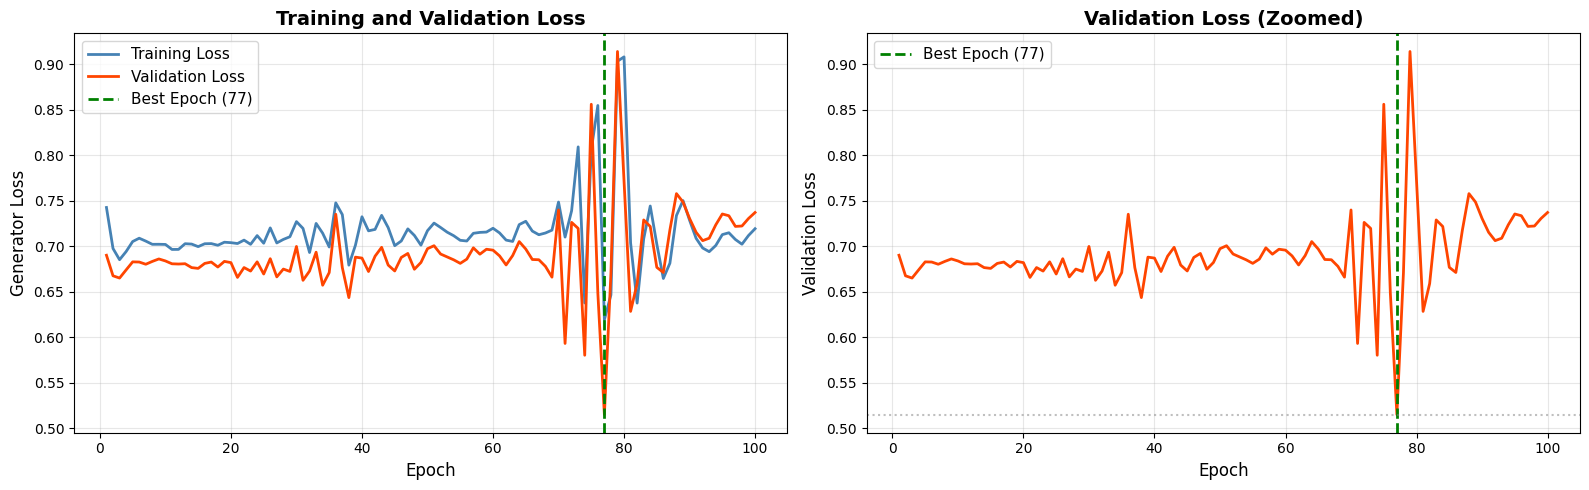


Training summary:
  - Final training loss: 0.7194
  - Final validation loss: 0.7372
  - Best validation loss: 0.5152 (epoch 77)
  - Overfitting check: Yes


In [19]:
# %%
# === SECTION 13E: Plot Training and Validation Loss ===

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Combined training and validation loss
epochs = range(1, len(train_losses) + 1)
ax1.plot(epochs, train_losses, label='Training Loss', linewidth=2, color='steelblue')
ax1.plot(epochs, val_losses, label='Validation Loss', linewidth=2, color='orangered')
ax1.axvline(x=best_epoch, color='green', linestyle='--', linewidth=2, 
            label=f'Best Epoch ({best_epoch})')
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Generator Loss', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Plot 2: Validation loss only (zoomed in)
ax2.plot(epochs, val_losses, linewidth=2, color='orangered')
ax2.axvline(x=best_epoch, color='green', linestyle='--', linewidth=2, 
            label=f'Best Epoch ({best_epoch})')
ax2.axhline(y=min(val_losses), color='gray', linestyle=':', alpha=0.5)
ax2.set_title('Validation Loss (Zoomed)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Loss', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('volgan_loss_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTraining summary:")
print(f"  - Final training loss: {train_losses[-1]:.4f}")
print(f"  - Final validation loss: {val_losses[-1]:.4f}")
print(f"  - Best validation loss: {min(val_losses):.4f} (epoch {best_epoch})")
print(f"  - Overfitting check: {'Yes' if val_losses[-1] > min(val_losses) * 1.1 else 'No'}")


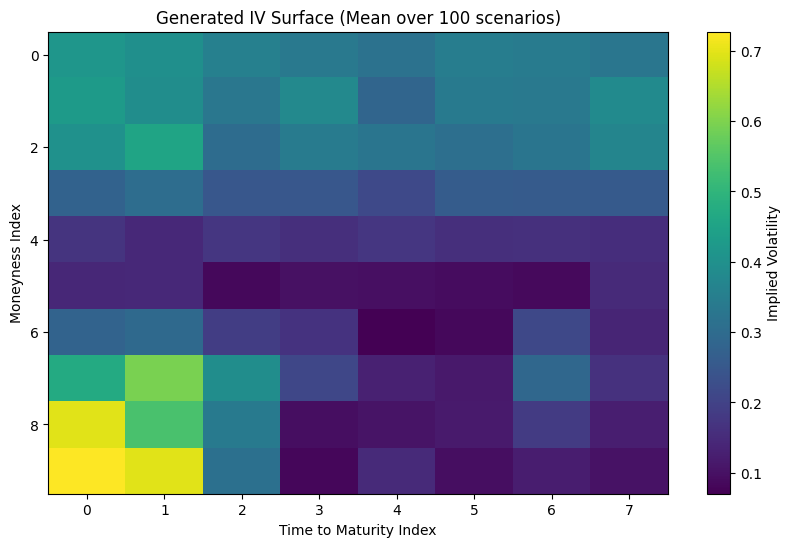

IV range: 0.070 to 0.727
Should be roughly: 0.10 to 0.40 for SPX


In [20]:
# Test generation
gen.eval()
with torch.no_grad():
    # Take one validation sample
    noise = torch.randn((100, gen.noise_dim), device=device)
    condition_sample = condition_val[0].unsqueeze(0).repeat(100, 1)
    fake = gen(noise, condition_sample)
    
    # Get IV surface
    log_iv_inc = fake[:, 1:].cpu().numpy()
    iv_current = np.exp(condition_sample[0, 3:].cpu().numpy())
    iv_generated = iv_current * np.exp(log_iv_inc.mean(axis=0))
    
    # Reshape and plot
    iv_surface = iv_generated.reshape(len(m), len(tau))
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.imshow(iv_surface, aspect='auto', cmap='viridis')
    plt.colorbar(label='Implied Volatility')
    plt.title('Generated IV Surface (Mean over 100 scenarios)')
    plt.xlabel('Time to Maturity Index')
    plt.ylabel('Moneyness Index')
    plt.show()
    
    print(f"IV range: {iv_surface.min():.3f} to {iv_surface.max():.3f}")
    print(f"Should be roughly: 0.10 to 0.40 for SPX")


In [22]:
# %%
# === SECTION 14: Load Best VolGAN Model (from validation) ===

gen = Generator(noise_dim=20, cond_dim=3+80, hidden_dim=128, output_dim=1+80)
gen.load_state_dict(torch.load('volgan_best.pt', map_location=device))  # ← Load best, not final!
gen.to(device)
gen.eval()
print(f"VolGAN model loaded successfully (best epoch: {best_epoch})")


VolGAN model loaded successfully (best epoch: 77)


Spot returns std: 0.00253


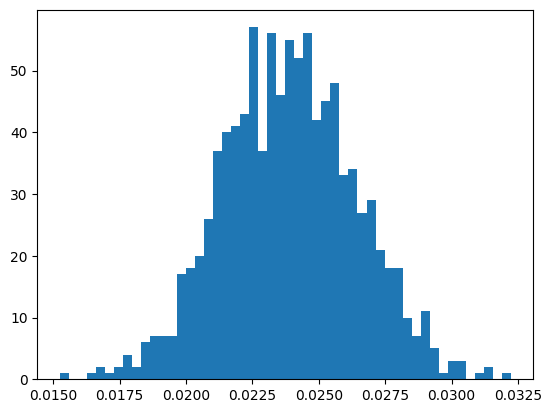

In [21]:

with torch.no_grad():
    noise = torch.randn((1000, gen.noise_dim), device=device)
    condition_sample = condition_test[0].unsqueeze(0).repeat(1000, 1)
    fake = gen(noise, condition_sample)
    spot_returns = fake[:, 0].cpu().numpy() / np.sqrt(252)
print(f"Spot returns std: {spot_returns.std():.5f}")
plt.hist(spot_returns, bins=50)
plt.show()


In [23]:
# === SECTION 15: Run VolGAN Backtest ===

m0_list = [0.75, 0.8, 0.9, 1.1, 1.2, 1.25]

results_volgan = run_volgan_experiment(
    df_1m_bt, gen, m0_list,
    condition_test_filtered,
    dates_test_filtered,
    m_grid, tau, max_windows=52, device=device
)

print(f"\nVolGAN results: {results_volgan.shape}")
results_volgan.head()


===== VolGAN: m0=0.75 =====
Window 1/31
Window 2/31
Window 3/31
Window 4/31
Window 5/31
Window 6/31
Window 7/31
Window 8/31
Window 9/31
Window 10/31
Window 11/31
Window 12/31
Window 13/31
Window 14/31
Window 15/31
Window 16/31
Window 17/31
Window 18/31
Window 19/31
Window 20/31
Window 21/31
Window 22/31
Window 23/31
Window 24/31
Window 25/31
Window 26/31
Window 27/31
Window 28/31
Window 29/31
Window 30/31
Window 31/31

===== VolGAN: m0=0.8 =====
Window 1/31
Window 2/31
Window 3/31
Window 4/31
Window 5/31
Window 6/31
Window 7/31
Window 8/31
Window 9/31
Window 10/31
Window 11/31
Window 12/31
Window 13/31
Window 14/31
Window 15/31
Window 16/31
Window 17/31
Window 18/31
Window 19/31
Window 20/31
Window 21/31
Window 22/31
Window 23/31
Window 24/31
Window 25/31
Window 26/31
Window 27/31
Window 28/31
Window 29/31
Window 30/31
Window 31/31

===== VolGAN: m0=0.9 =====
Window 1/31
Window 2/31
Window 3/31
Window 4/31
Window 5/31
Window 6/31
Window 7/31
Window 8/31
Window 9/31
Window 10/31
Window

,start,end,m0,V0,V_T,Pi_T,tracking_error,pnl_unhedged,pnl_hedged,strategy
0,2021-01-04,2021-02-03,0.75,931.000,1057.075,1055.144907,1.930093,126.075,124.144907,VolGAN
1,2021-02-03,2021-03-05,0.75,956.625,966.975,969.665306,-2.690306,10.350,13.040306,VolGAN
2,2021-05-05,2021-06-04,0.75,1039.175,1103.725,1096.491783,7.233217,64.550,57.316783,VolGAN
3,2021-06-04,2021-07-06,0.75,1059.575,1172.850,1204.955575,-32.105575,113.275,145.380575,VolGAN
4,2021-08-04,2021-09-02,0.75,1100.950,1234.650,1251.290494,-16.640494,133.700,150.340494,VolGAN


In [24]:
# === SECTION 16: Summary Statistics ===

summary_volgan = results_volgan.groupby('m0')['tracking_error'].agg([
    'mean', 'median', 'std',
    ('VaR_5%', lambda x: x.quantile(0.05))
]).round(3)

print("\nVolGAN Tracking Error Summary:")
print(summary_volgan)


VolGAN Tracking Error Summary:
        mean  median     std  VaR_5%
m0                                  
0.75  12.617   7.233  34.039 -28.300
0.80   3.277   5.053   7.515 -10.828
0.90  16.708  12.949  14.223   1.156
1.10  23.298   6.682  37.641  -6.805


/var/folders/lf/j1p7b9893pb19dwl2jcxhw900000gn/T/ipykernel_95028/1997402176.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='m0', y='tracking_error', data=results_volgan, palette='Set2')


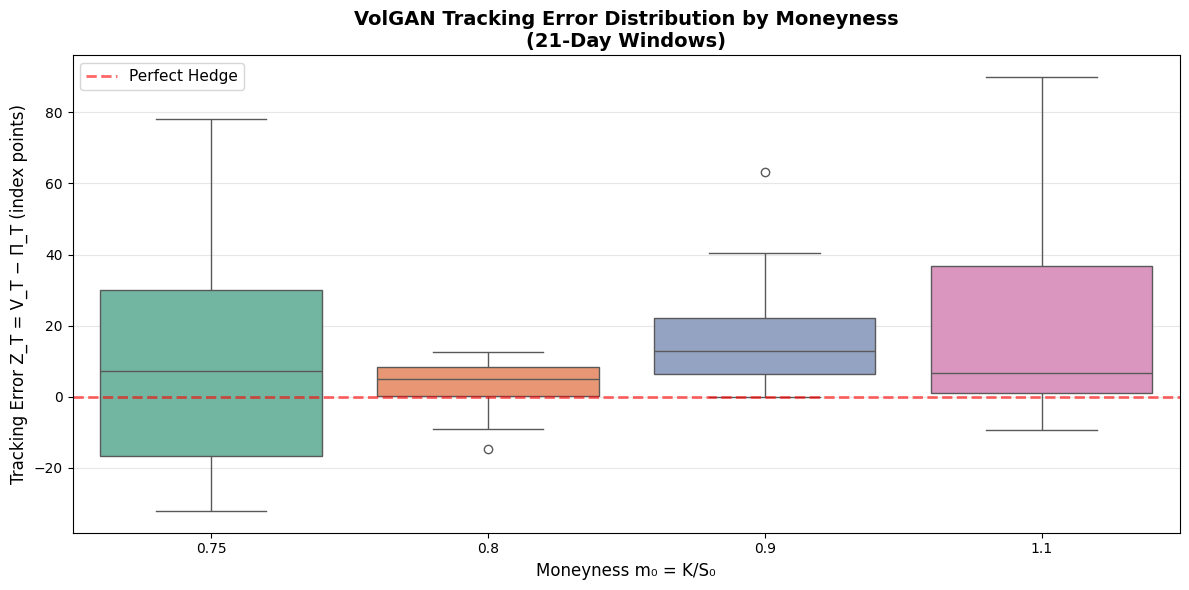

In [25]:
# === SECTION 17: VolGAN Results — Box Plot by Moneyness ===

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(x='m0', y='tracking_error', data=results_volgan, palette='Set2')
plt.title('VolGAN Tracking Error Distribution by Moneyness\n(21-Day Windows)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Moneyness m₀ = K/S₀', fontsize=12)
plt.ylabel('Tracking Error Z_T = V_T − Π_T (index points)', fontsize=12)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.6, linewidth=2, label='Perfect Hedge')
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [26]:
# === SECTION 18: Summary Statistics Table ===

summary_volgan = results_volgan.groupby('m0')['tracking_error'].agg([
    ('Count', 'count'),
    ('Mean', 'mean'),
    ('Median', 'median'),
    ('Std Dev', 'std'),
    ('Min', 'min'),
    ('Max', 'max'),
    ('VaR 5%', lambda x: x.quantile(0.05)),
    ('VaR 1%', lambda x: x.quantile(0.01))
]).round(3)

print("\n" + "="*80)
print("VolGAN Tracking Error Summary by Moneyness")
print("="*80)
print(summary_volgan)
print("="*80)


VolGAN Tracking Error Summary by Moneyness
      Count    Mean  Median  Std Dev     Min     Max  VaR 5%  VaR 1%
m0                                                                  
0.75     13  12.617   7.233   34.039 -32.106  78.138 -28.300 -31.344
0.80     15   3.277   5.053    7.515 -14.766  12.511 -10.828 -13.979
0.90     26  16.708  12.949   14.223  -0.144  63.253   1.156   0.147
1.10      6  23.298   6.682   37.641  -9.365  89.897  -6.805  -8.853


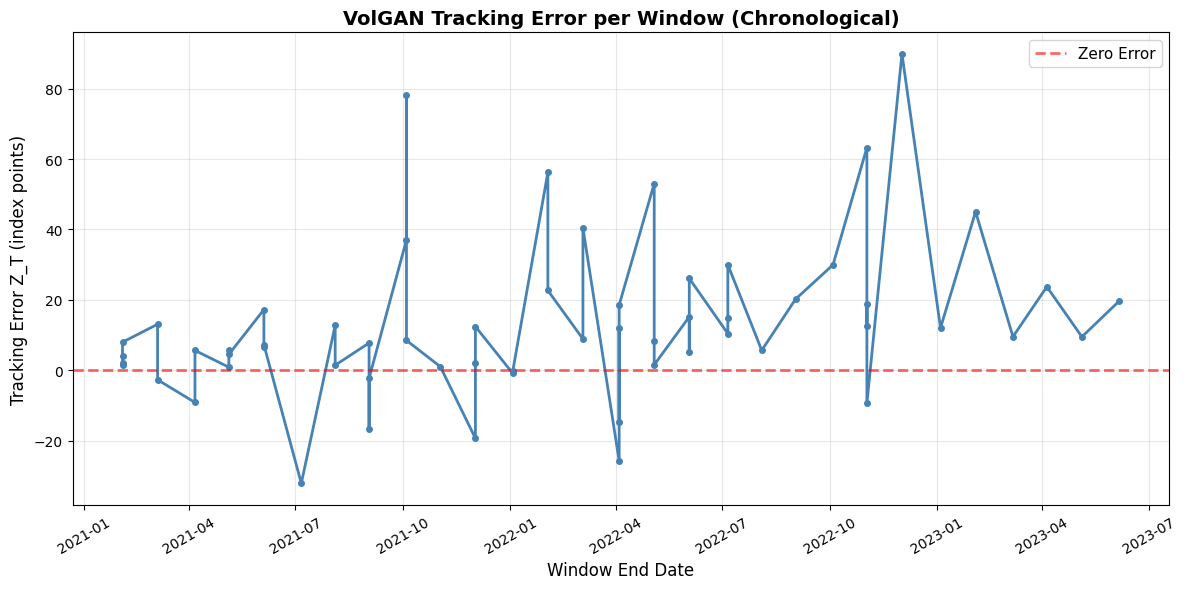

In [27]:
# === SECTION 19: Tracking Error Time Series ===

res = results_volgan.sort_values('end').reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(res['end'], res['tracking_error'], marker='o', color='steelblue', 
         linewidth=2, markersize=4)
plt.axhline(0, color='red', linestyle='--', alpha=0.6, linewidth=2, label='Zero Error')
plt.title('VolGAN Tracking Error per Window (Chronological)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Window End Date', fontsize=12)
plt.ylabel('Tracking Error Z_T (index points)', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=11)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

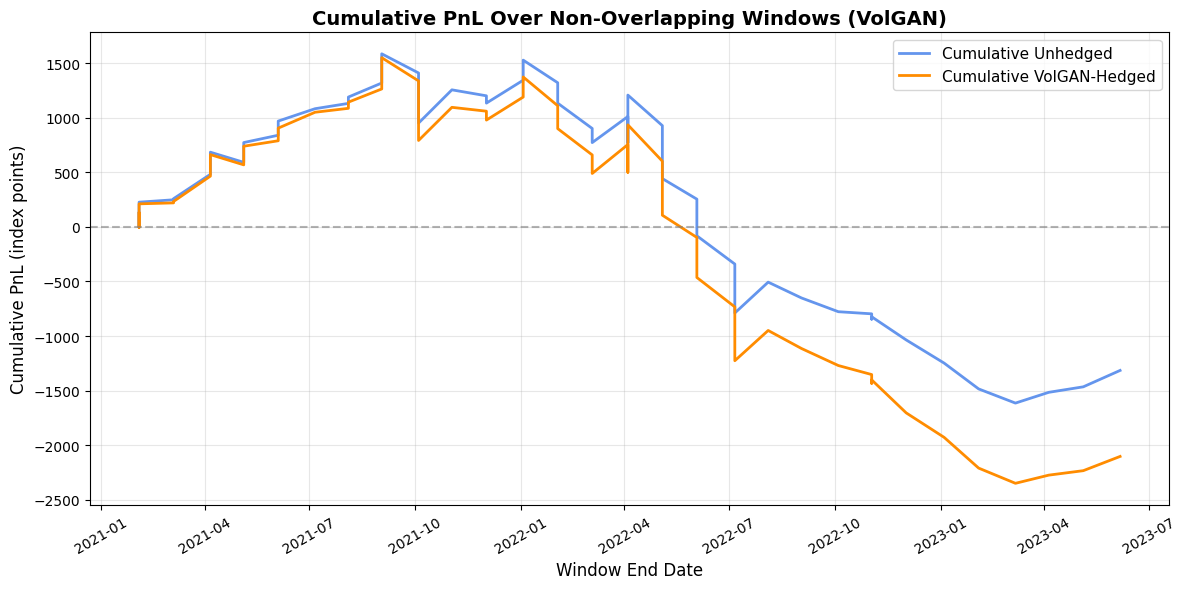

In [28]:
# === SECTION 20: Cumulative PnL (Hedged vs Unhedged) ===

res = results_volgan.sort_values('end').reset_index(drop=True)
res['cum_unhedged'] = res['pnl_unhedged'].cumsum()
res['cum_hedged'] = res['pnl_hedged'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(res['end'], res['cum_unhedged'], label='Cumulative Unhedged', 
         color='cornflowerblue', linewidth=2)
plt.plot(res['end'], res['cum_hedged'], label='Cumulative VolGAN-Hedged', 
         color='darkorange', linewidth=2)
plt.axhline(0, color='gray', linestyle='--', alpha=0.6)
plt.title('Cumulative PnL Over Non-Overlapping Windows (VolGAN)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Window End Date', fontsize=12)
plt.ylabel('Cumulative PnL (index points)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

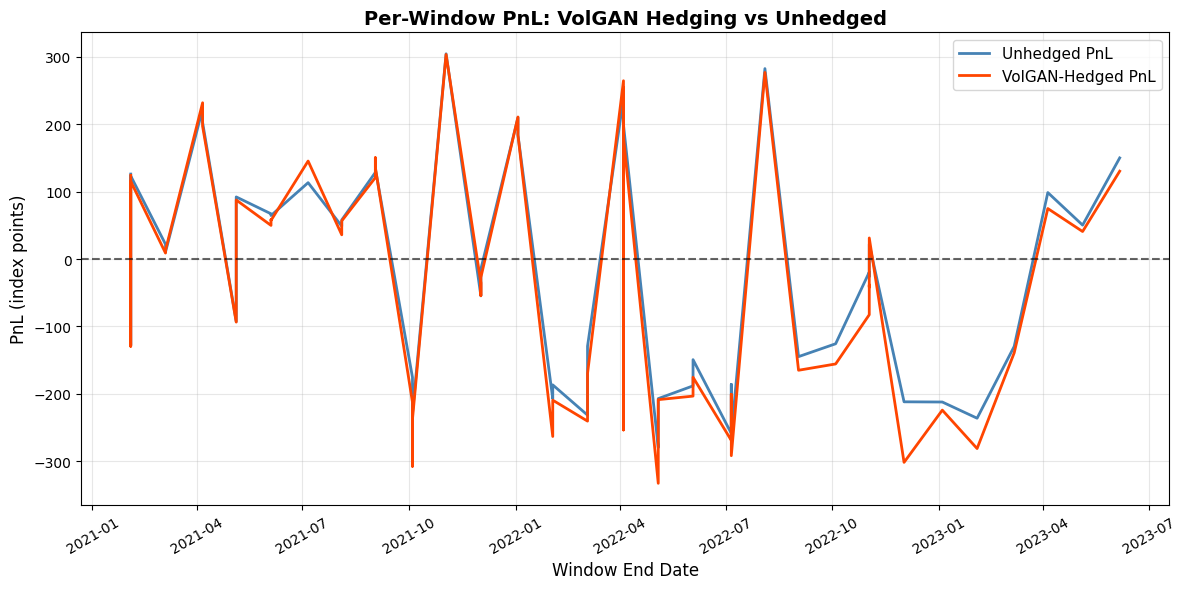

In [29]:
# === SECTION 21: Per-Window PnL (Hedged vs Unhedged) ===

res = results_volgan.sort_values('end').reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(res['end'], res['pnl_unhedged'], label='Unhedged PnL', 
         color='steelblue', linewidth=2)
plt.plot(res['end'], res['pnl_hedged'], label='VolGAN-Hedged PnL', 
         color='orangered', linewidth=2)
plt.axhline(0, linestyle='--', color='black', alpha=0.6)
plt.title('Per-Window PnL: VolGAN Hedging vs Unhedged', 
          fontsize=14, fontweight='bold')
plt.xlabel('Window End Date', fontsize=12)
plt.ylabel('PnL (index points)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()




In [30]:
# save to csv
results_volgan.to_csv('results_volgan_valid.csv', index=False)
print("Delta results saved to results_volgan_valid.csv")

Delta results saved to results_volgan_valid.csv
